# Prediction Intervals for Taxi Fares using Quantile Loss

Uncertainty estimation can be especially difficult when the data is [heteroskedastic](https://en.wikipedia.org/wiki/Heteroscedasticity), that is, when the variance of the target variable changes across the value of the predictors.  The [quantile loss](https://en.wikipedia.org/wiki/Quantile_regression) can be used with most loss-based regression techniques to estimate predictive intervals (by estimating the value of a certain quantile of the target variable at any point in feature-space).

New York City releases their [taxi ride data](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml), and Kaggle hosts a subset of the data
[here](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data), which we'll use for this post.

## Setup

Below we'll be predicting taxi fares from pickup and dropoff location and times using [catboost](https://catboost.ai/), an implementation of gradient boosted decision trees.  We'll also be using [vaex](https://github.com/vaexio/vaex) for visualization. Both can be installed via pip:

In [0]:
!pip install -q tf-nightly
!pip install -q tfp-nightly
!pip install -q catboost
!pip install -q --pre vaex

Then we can load the packages we'll use.

In [0]:
# Packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import vaex
from sklearn.dummy import DummyRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict
from catboost import CatBoostRegressor
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

# Settings
sns.set()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%config InlineBackend.figure_format = 'svg'
np.random.seed(111)
tf.set_random_seed(111)

## Data

We'll be predicting taxi fares given pickup/dropoff locations and ride times, using the [New York City Taxi Fare dataset](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data).  First we'll load the information from the dataset concerning fares, times, and pickup/dropoff locations.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
%%time

# Columns to load
dtypes = {'fare_amount':      'float32',
          'pickup_datetime':  'str', 
          'pickup_longitude': 'float32',
          'pickup_latitude':  'float32',
          'dropoff_longitude':'float32',
          'dropoff_latitude': 'float32'}

# Load data
#train = pd.read_csv('train.csv', 
train = pd.read_csv('/content/gdrive/My Drive/DataScience/Data/train.zip', 
                    usecols=dtypes.keys(), 
                    dtype=dtypes,
                    nrows=200000)

# Convert pickup time column to datetime
train['pickup_datetime'] = train['pickup_datetime'].str.slice(0, 16)
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], 
                                          utc=True, format='%Y-%m-%d %H:%M')

CPU times: user 715 ms, sys: 60.8 ms, total: 776 ms
Wall time: 1.83 s


Now we can take a peek at the dataset we loaded.

In [0]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,4.5,2009-06-15 17:26:00+00:00,-73.844315,40.721317,-73.841614,40.712276
1,16.9,2010-01-05 16:52:00+00:00,-74.016045,40.711304,-73.979271,40.782005
2,5.7,2011-08-18 00:35:00+00:00,-73.982735,40.761269,-73.991241,40.750561
3,7.7,2012-04-21 04:30:00+00:00,-73.987129,40.733143,-73.991570,40.758091
4,5.3,2010-03-09 07:51:00+00:00,-73.968094,40.768009,-73.956657,40.783764


How many null values there are in each column?

In [0]:
print('Column\tPercent Null')
for col in train:
    print(col, 100*train[col].isnull().sum()/train.shape[0])

Column	Percent Null
fare_amount 0.0
pickup_datetime 0.0
pickup_longitude 0.0
pickup_latitude 0.0
dropoff_longitude 0.0006784082291206876
dropoff_latitude 0.0006784082291206876


There are some null values, but a negligible amount of them, so we'll just remove rows with null values.

In [0]:
train.dropna(inplace=True)

Instead of using the raw time, let's extract useful features from the time like the time of day, day of the week, day of the year, and the year.

In [0]:
# Extract useful time information
train['min_of_day'] = (60*train['pickup_datetime'].dt.hour + 
                       train['pickup_datetime'].dt.minute).astype('int32')
train['day_of_week'] = train['pickup_datetime'].dt.dayofweek.astype('int32')
train['day_of_year'] = train['pickup_datetime'].dt.dayofyear.astype('int32')
train['year'] = train['pickup_datetime'].dt.year.astype('int32')

# Remove original datetime column
train.drop('pickup_datetime', axis=1, inplace=True)

Let's check the fare amount distributions:

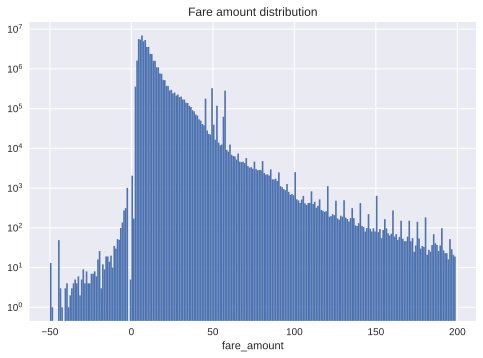

In [0]:
# Plot distribution of fares
plt.hist(train['fare_amount'], 
         bins=np.arange(-50, 200),
         log=True)
plt.xlabel('fare_amount')
plt.title('Fare amount distribution')
plt.show()

It looks like there are some oddly large values, along with negative values (which doesn't make any sense, of course! Hopefully NYC taxi drivers aren't so desperate for business that they pay people to take rides with them...). Let's remove the datapoints with fares which are suspiciously low, and also rides with suspiciously high fares.

In [0]:
# Function to remove rows outside range
def clip(df, a, b, col):
    for c in col:
        df = df[(df[c]>a) & (df[c]<b)]
    return df

# Remove rows with outlier fare values
train = clip(train, 1, 200, ['fare_amount'])

Finally, let's check the locations of the pickups and dropoffs.

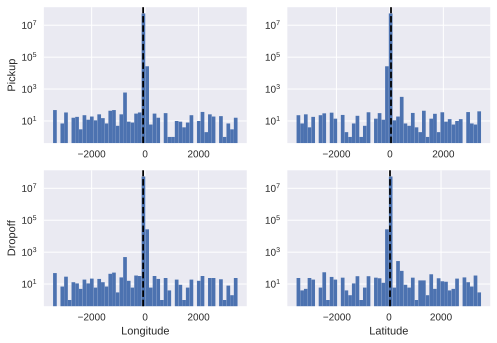

In [0]:
# Plot distribution of pickup longitudes
fig, ax = plt.subplots(2, 2)
nyc_lon = -74
nyc_lat = 40.7
ax[0,0].axvline(nyc_lon, linestyle='--', color='k')
ax[0,0].hist(train['pickup_longitude'], bins=50, log=True)
ax[0,0].set_ylabel('Pickup')
ax[1,0].axvline(nyc_lon, linestyle='--', color='k')
ax[1,0].hist(train['dropoff_longitude'], bins=50, log=True)
ax[1,0].set_xlabel('Longitude')
ax[1,0].set_ylabel('Dropoff')
ax[0,1].axvline(nyc_lat, linestyle='--', color='k')
ax[0,1].hist(train['pickup_latitude'], bins=50, log=True)
ax[1,1].axvline(nyc_lat, linestyle='--', color='k')
ax[1,1].hist(train['dropoff_latitude'], bins=50, log=True)
ax[1,1].set_xlabel('Latitude')
plt.show()

There are some pretty unreasonable outliers: longitudes can only lie between -180 and 180, and latitudes between -90 and 90.  Let's remove rows with geographical locations outside a reasonable range (near the greater NYC metropolitan area).

In [0]:
# Remove geographical outliers
train = clip(train,  -75, -72.5,
             ['pickup_longitude', 'dropoff_longitude'])
train = clip(train, 40, 41.5,
             ['pickup_latitude', 'dropoff_latitude'])

And now we have only values which are near NYC:

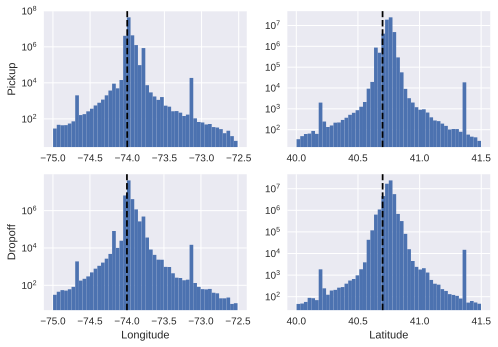

In [0]:
# Plot distribution of pickup longitudes
fig, ax = plt.subplots(2, 2)
nyc_lon = -74
nyc_lat = 40.7
ax[0,0].axvline(nyc_lon, linestyle='--', color='k')
ax[0,0].hist(train['pickup_longitude'], bins=50, log=True)
ax[0,0].set_ylabel('Pickup')
ax[1,0].axvline(nyc_lon, linestyle='--', color='k')
ax[1,0].hist(train['dropoff_longitude'], bins=50, log=True)
ax[1,0].set_xlabel('Longitude')
ax[1,0].set_ylabel('Dropoff')
ax[0,1].axvline(nyc_lat, linestyle='--', color='k')
ax[0,1].hist(train['pickup_latitude'], bins=50, log=True)
ax[1,1].axvline(nyc_lat, linestyle='--', color='k')
ax[1,1].hist(train['dropoff_latitude'], bins=50, log=True)
ax[1,1].set_xlabel('Latitude')
plt.show()

Let's plot the taxi pickup locations.

In [0]:
# Create vaex df from pandas df
vdf = vaex.from_pandas(train)

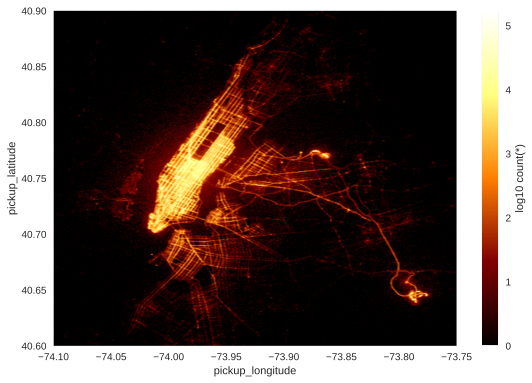

In [0]:
# Plot pickup locations as a heatmap
lims = [[-74.1, -73.75],[40.6, 40.9]]
cmap = matplotlib.cm.afmhot
cmap.set_bad('black', 1.)
vdf.plot('pickup_longitude', 'pickup_latitude', 
         limits=lims, colormap=cmap,
         f='log10', shape=500, 
         interpolation='spline16')

# Turn off grid
plt.gca().grid(False)

We can see that there's a very high density of pickups in downtown Manhattan, and also on main streets across the river to the east in and around Brooklyn.  The high-density area around (40.77,-73.87) is the La Guardia airport, and the other high-density area in the lower right is the John F. Kennedy airport.

If we zoom in on downtown Mannhattan, we can see that taxi's GPS signals are more noisy in [areas of Manhattan which have skyscrapers](https://www.google.com/maps/@40.6676922,-73.9998037,8871a,35y,3.76h,37.64t/data=!3m1!1e3).

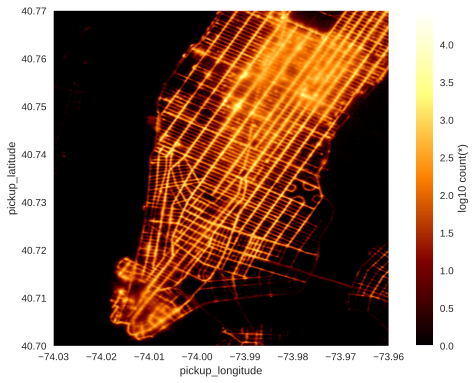

In [0]:
# Plot pickup locations as a heatmap
lims = [[-74.03, -73.96],[40.70, 40.77]]
vdf.plot('pickup_longitude', 'pickup_latitude', 
         limits=lims, colormap=cmap,
         f='log10', shape=700, 
         interpolation='spline16', aspect='equal')

# Turn off grid
plt.gca().grid(False)

Let's also plot the dropoff locations.

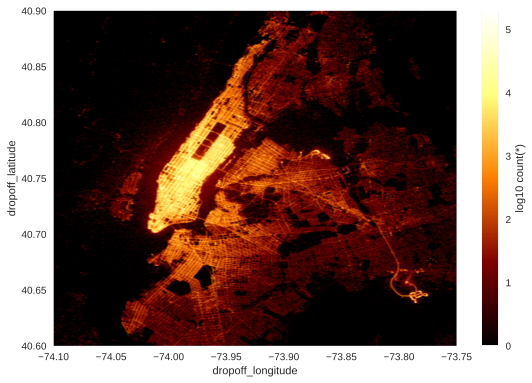

In [0]:
# Plot pickup locations as a heatmap
lims = [[-74.1, -73.75],[40.6, 40.9]]
vdf.plot('dropoff_longitude', 'dropoff_latitude', 
         limits=lims, colormap=cmap,
         f='log10', shape=500, 
         interpolation='spline16',
         background_color='black', background_alpha=0)

# Turn off grid
plt.gca().grid(False)

The dropoff location distribution looks pretty similar to the pickup locations distribution, except there are a higher density of dropoffs in residential areas within Brooklyn (across the river to the east of Manhattan).  

We can also plot the difference between pickup and dropoff locations. First we'll create a divergent colormap (to visualize more pickups vs more dropoffs vs no difference), and then we'll create a function to plot the difference given the dataframe and coordinates.

In [0]:
# Create a divergent colormap
c_data = [
           [ 0.8, 0.8, 1.0],
           [ 0.3, 0.4, 0.8],
           [ 0.1, 0.2, 0.5],
           [ 0.0, 0.0, 0.0],
           [ 0.5, 0.2, 0.1],
           [ 0.8, 0.4, 0.3],
           [ 1.0, 0.8, 0.8]
]
BluRdDiv = (matplotlib.colors.
            LinearSegmentedColormap.
            from_list('BluRdDiv', c_data))
plt.register_cmap(cmap=BluRdDiv)

# Function to plot difference in pickups/dropoffs
def PlotDiff(df, lims, shape=500, cmap='BluRdDiv'):
  p_count = df.count(
      binby=[df.pickup_longitude, 
             df.pickup_latitude],
      limits=lims, shape=shape)
  d_count = df.count(
      binby=[df.dropoff_longitude, 
             df.dropoff_latitude],
      limits=lims, shape=shape)
  log_diffs = ( np.log(np.abs(d_count-p_count)) * 
                np.sign(d_count-p_count) )
  t_cmap = plt.get_cmap(cmap)
  t_cmap.set_bad('black', 1.)
  vlim = np.nanmax(np.abs(log_diffs))
  plt.imshow(log_diffs.T, origin='lower', 
             cmap=t_cmap, vmin=-vlim, vmax=vlim,
             extent=[lims[0][0], lims[0][1], 
                     lims[1][0], lims[1][1]])
  ax = plt.gca()
  ax.grid(False)
  cbar = plt.colorbar()
  cbar.set_label('log(dropoffs-pickups)', rotation=270)


Now we can plot the difference between the number of pickups and dropoffs.  Red areas in the plot below are locations where there are more pickups than dropoffs, and blue areas are locations where there are more dropoffs than pickups.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


Text(0.5,1,'Pickup/Dropoff Difference')

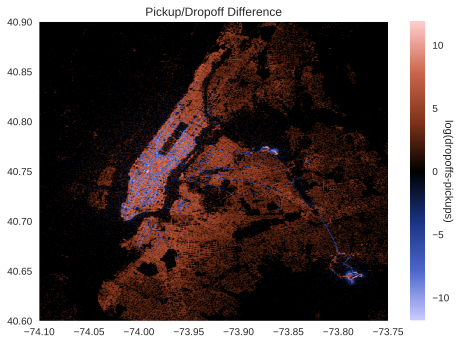

In [0]:
# Plot difference in pickup/dropoff locations
lims = [[-74.1, -73.75],[40.6, 40.9]]
PlotDiff(vdf, lims)
plt.title('Pickup/Dropoff Difference')

Zooming in on downtown Manhattan, we can see that more pickups occur on main north/south avenues, and more dropoffs occur on the smaller east/west streets.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


Text(0.5,1,'Pickup/Dropoff Difference Downtown')

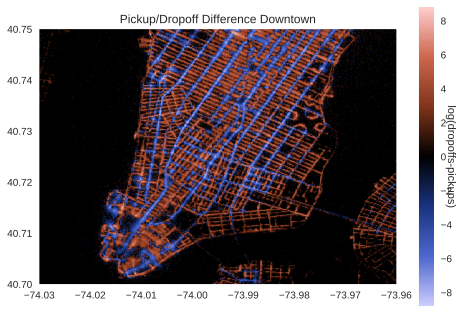

In [0]:
# Plot difference downtown
lims = [[-74.03, -73.96],[40.70, 40.75]]
PlotDiff(vdf, lims)
plt.title('Pickup/Dropoff Difference Downtown')

Zooming in on La Guardia airport, we can see the separate departure (more dropoffs) and arrival (more pickups) areas.  The departure dropoff area is on the top level, while arrival pickup area is on a lower level, leading to less accurate GPS signals, causing the more diffuse spread of the pickup location points.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


Text(0.5,1,'Pickup/Dropoff Difference at La Guardia')

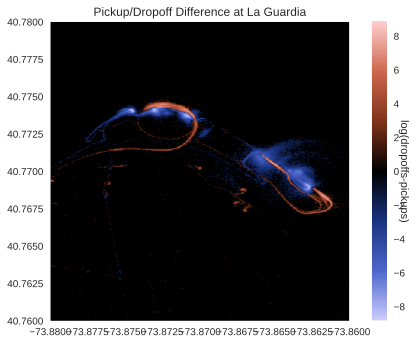

In [0]:
# Plot difference around La Guardia
lims = [[-73.88, -73.86],[40.76, 40.78]]
PlotDiff(vdf, lims)
plt.title('Pickup/Dropoff Difference at La Guardia')

And we can see a similar pattern at JFK International Airport.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


Text(0.5,1,'Pickup/Dropoff Difference at JFK Airport')

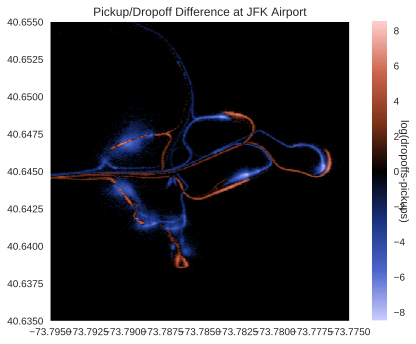

In [0]:
# Plot difference around JFK
lims = [[-73.795, -73.775],[40.635, 40.655]]
PlotDiff(vdf, lims)
plt.title('Pickup/Dropoff Difference at JFK Airport')

## Model

Let's use some simple models to try and predict the taxi fares from pickup/dropoff locations and times.  First we have to split the dataset into our features and target variables, and then we'll create a function which computes the mean absolute deviation between a given model's predictions and the true values.  Also, we'll only use the first million rows for training the model.

In [0]:
# Separate in- from dependent variables
x_taxi = train.drop('fare_amount', axis=1)
y_taxi = train['fare_amount']

# Take only 1st million rows
take_n = 1000000
x_taxi = x_taxi[:take_n]
y_taxi = y_taxi[:take_n]

# Make Mean Absolute Error scorer
mae_scorer = make_scorer(mean_absolute_error)

# Function to print cross-validated mean abs deviation
def cv_mae(regressor, x, y, cv=3, scorer=mae_scorer):
    scores = cross_val_score(regressor, 
                             x, y, cv=cv,
                             scoring=scorer)
    print('MAE:', scores.mean())

How accurate can we be if we simply always predict the mean?  We'll use [Scikit-learn](https://scikit-learn.org)'s [`DummyRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html), which predicts the mean by default.

In [0]:
# MAE from predicting just the mean
cv_mae(DummyRegressor(), x_taxi, y_taxi)

MAE: 5.991544246673584


So, just by predicting the mean we can get within $6, on average.

What if we just use the distance of the trip as a predictor?  First we'll compute the euclidian distance between the pickup and dropoff location.  The distances are relatively small, since these are taxi trips within the NYC metropolitan area, so we won't worry about computing the [haversine distance](https://en.wikipedia.org/wiki/Haversine_formula) (which accounts for the curvature of the earth - if we were predicting say, airfares, we might want to use haversine distance).  Then we'll predict the fare based only on the distance using an [isotonic regression](https://en.wikipedia.org/wiki/Isotonic_regression), which assumes that the fare monotonically increases with distance.

In [0]:
# Distance between pickup and dropoff locations
dist = np.sqrt(
    np.power(x_taxi['pickup_longitude'] -
             x_taxi['dropoff_longitude'], 2) + 
    np.power(x_taxi['pickup_latitude'] - 
             x_taxi['dropoff_latitude'], 2))

# MAE from using just distance as predictor
cv_mae(IsotonicRegression(out_of_bounds='clip'), 
       dist, y_taxi)

MAE: 2.34644575380712


This results in much better predictions than just guessing the mean.  Using only the distance, we can on average predict the taxi fare within $2.30.

Finally, we can get down to a mean absolute error of close to $2 if we use all the information available to us (pickup/dropoff locations and the time of pickup), with gradient boosted decision trees ([catboost](https://catboost.ai), specifically).

In [0]:
# Cross-validated MAE w/ CatBoost
cv_mae(CatBoostRegressor(logging_level='Silent'), 
       x_taxi, y_taxi)

MAE: 1.9706949328378502


## Heteroskedasticity

One thing we need to look out for when predicting uncertainty is [heteroskedasticity](https://en.wikipedia.org/wiki/Heteroscedasticity)!  Heteroskedasticity is when the variance of the predicted variable (the dependent variable, in our case the taxi fare amounts) changes as a function of the features (the independent variables, in our case the pickup/dropoff locations and times).

However, simple models often can't capture variance in the dependent variable when it changes as a function of the independent variable.  For example, a simple linear model

$$
y = mx + b + \epsilon
$$

usually assumes that the noise term is normally distributed,

$$
\epsilon \sim \mathcal{N}(0, \sigma)
$$

But this assumes that the variance of the normally-distributed noise ($\sigma$) isn't changing as a function of $x$!  In a lot of real-world data, the variance of $y$ changes as a function of $x$.  Let's generate some heteroskedastic data just to see what that looks like.


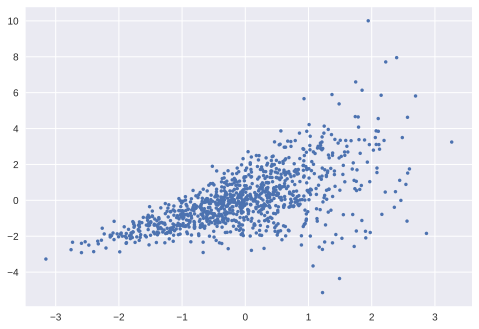

In [0]:
# A function to generate heteroskedastic data
def h_func(x):
    return x + np.exp(0.5*x)*np.random.randn(x.shape[0],1)

# Generate heteroskedastic data
N = 1000
x = np.atleast_2d(np.random.randn(N)).T
y = h_func(x).ravel()

# Generate validation data
x_val = np.atleast_2d(np.random.randn(N)).T
y_val = h_func(x_val).ravel()

# Plot data we generated
plt.plot(x, y, '.')
plt.show()

Is our taxi fares data heteroskedastic?

Text(0.5,1,'Fare amount by Distance')

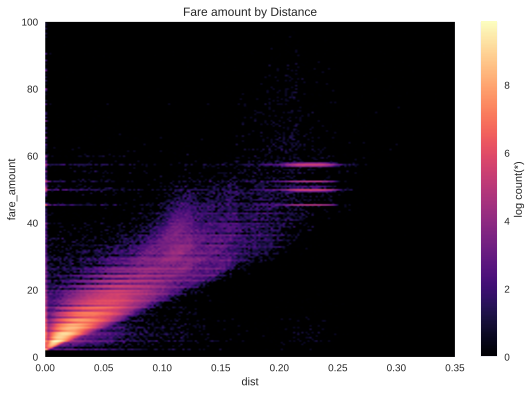

In [0]:
# Add distance to vaex df
train['dist'] = dist
vdf = vaex.from_pandas(train)

# Plot distance vs fare amount
lims = [[0, 0.35],[0, 100]]
cmap = matplotlib.cm.magma
cmap.set_bad('black', 1.)
vdf.plot('dist', 'fare_amount', 
         limits=lims,
         f='log', 
         colormap=cmap,
         shape=200, 
         interpolation='spline16')
ax = plt.gca().grid(False)
plt.title('Fare amount by Distance')

Indeed it looks like the true data is heteroskedastic - the variance of the fare amount appears to increase with the distance of the trip.  Also keep in mind that above we plotted the fare against only the *distance*, whereas the full dataset has pickup/dropoff location, time of day, time of year, etc.  Let's plot the fare amount across time.






Text(0.5,1,'Fare amount by Time')

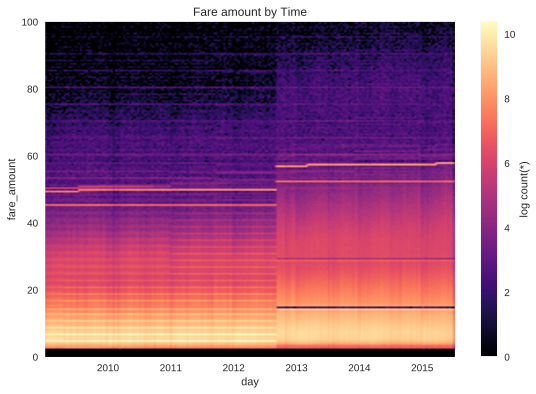

In [0]:
# Add distance to vaex df
train['day'] = dist
vdf = vaex.from_pandas(train)
vdf['day'] = vdf.day_of_year + 365*vdf.year

# Plot distance vs fare amount
lims = [[2009*365, 2015.52*365],[0, 100]]
cmap = matplotlib.cm.magma
cmap.set_bad('black', 1.)
vdf.plot('day', 'fare_amount', 
         limits=lims,
         f='log', 
         colormap=cmap,
         shape=200, 
         interpolation='spline16')
ax = plt.gca().grid(False)
plt.xticks(365*np.arange(2010, 2016),
           tuple(str(y) for y in np.arange(2010,2016)))
plt.title('Fare amount by Time')

The $y$-values are heteroskedastic as a function of time as well! How about over pickup location?

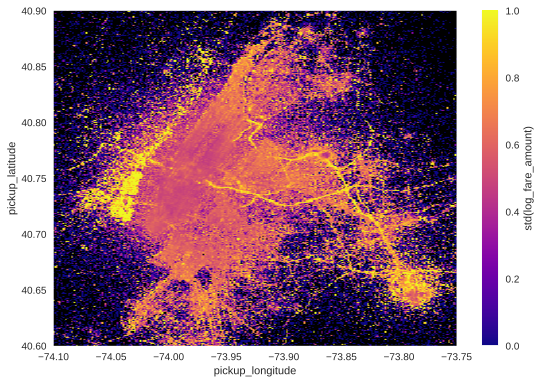

In [0]:
# Plot pickup locations as a heatmap
vdf['log_fare_amount'] = np.log(vdf.fare_amount)
lims = [[-74.1, -73.75],[40.6, 40.9]]
cmap = matplotlib.cm.plasma
cmap.set_bad('black', 1.)
vdf.plot('pickup_longitude', 'pickup_latitude', 
         what='std(log_fare_amount)',
         limits=lims, colormap=cmap,
         vmin=0, vmax=1.,
         shape=300)

# Turn off grid
plt.gca().grid(False)

The variance also changes across pickup location!  The fares are much more variable when the pickup is across the Hudson river in Jersey City and Hoboken than it is in, say, downtown Manhattan.  To deal with this heteroskedasticity, we can't assume a constant error.  Instead, we have to allow our estimate of uncertainty to vary across data-space.  One way to do this is to use a quantile regression.

Side note: in the plot above of fares vs time, you can see the flat-rate fee to La Guardia and JFK airports undergo a price hike at the end of summer 2012!  And then the price of the JFK flat-rate continue to creep up afterwards.  You can also see that there was some sort of constant interval charge before that period, whereas after prices are more continuous.  Perhaps there was a subset of cab companies which charged ~$2 per mile and rounded up to the nearest mile - probably via the odometer - but switched to charging a continuous rate per distance in mid 2012.

## Quantile Regression

What if we now want to predict our uncertainty as to our estimate, instead of only coming up with a single best estimate?  Predicting an estimate and the uncertainty as to that estimate seems especially challenging when that uncertainty varies with our independent variables.  A quantile regression is one method for estimating uncertainty which can be used with our model (gradient boosted decision trees).

With a quantile regression we can separately estimate the expected value, the upper bound of the (say, 95%) predictive interval, and the lower bound of the predictive interval.  That is, we're predicting not just the mean, but also the 97.5-th *quantile* of the data, and the 2.5-th quantile.

To do this we can just change the loss function we're using.  Instead of minimizing a defualt loss like the sum of squared error, we minimize the quantile loss for a choosen quantile value $q$.  The quantile loss for true values $y$, the predicted values $\hat{y}_i$, and a desired quantile $q$ (from 0 to 1) is

$$
L_q(y,\hat{y}) = (q-1) \sum_{i \in y_i<\hat{y}_i} |y_i-\hat{y}_i| + q \sum_{i \in y_i \geq \hat{y}_i} |y_i-\hat{y}_i|
$$

The closer the desired quantile is to 0%, the more this loss function penalizes estimates when they are above the true value.  The closer the desired quantile gets to 100%, the more the loss function penalizes estimates which are *less* than the true value.



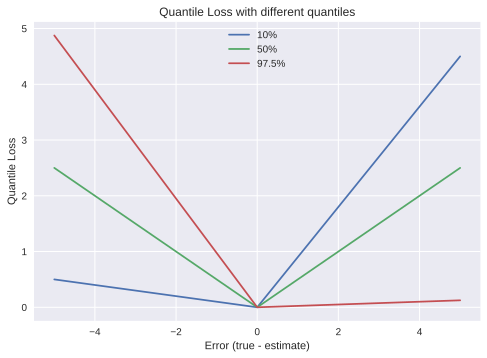

In [0]:
# Quantile loss function
def QuantileLoss(y_true, y_est, quantile):
  if type(y_true) is not np.ndarray:
    y_true = np.array(y_true)*np.ones_like(y_est)
  ix = (y_true<y_est)
  loss = np.zeros_like(y_est)
  loss[ix] = ((1-quantile) * 
               np.abs(y_true[ix]-y_est[ix]))
  loss[~ix] = (quantile * 
               np.abs(y_true[~ix]-y_est[~ix]))
  return loss
  
# Show loss @ different quantiles
xx = np.linspace(-5, 5, 101)
plt.plot(xx, QuantileLoss(0, xx, 0.1), label='10%')
plt.plot(xx, QuantileLoss(0, xx, 0.5), label='50%')
plt.plot(xx, QuantileLoss(0, xx, 0.975), label='97.5%')
plt.legend()
plt.title('Quantile Loss with different quantiles')
plt.xlabel('Error (true - estimate)')
plt.ylabel('Quantile Loss')
plt.show()

Let's see how we can use the gradient boosted decision trees model to estimate the predictive intervals on our dummy validation dataset.

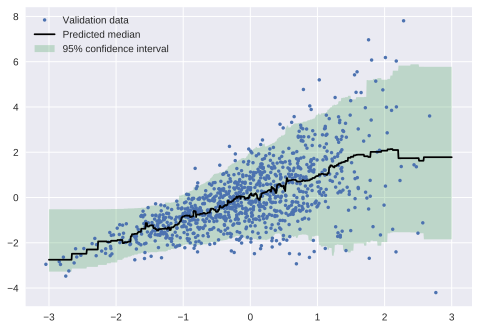

In [0]:
# Gradient boosted tree regressors w/ different quantile losses
gbrL = CatBoostRegressor(loss_function='Quantile:alpha=0.025', logging_level='Silent')
gbr = CatBoostRegressor(loss_function='Quantile:alpha=0.5', logging_level='Silent')
gbrH = CatBoostRegressor(loss_function='Quantile:alpha=0.975', logging_level='Silent')

# Using scikit-learn's gradient boosted decision trees
#from sklearn.ensemble import GradientBoostingRegressor
#gbrL = GradientBoostingRegressor(loss='quantile', alpha=0.025)
#gbr = GradientBoostingRegressor(loss='quantile', alpha=0.5)
#gbrH = GradientBoostingRegressor(loss='quantile', alpha=0.975)

# Fit to data
gbrL.fit(x, y)
gbr.fit(x, y)
gbrH.fit(x, y)

# Predict over x range
xx = np.atleast_2d(np.linspace(-3, 3, N)).T
y_predL = gbrL.predict(xx)
y_pred = gbr.predict(xx)
y_predH = gbrH.predict(xx)

# Plot predictions over points
plt.figure()
plt.plot(x_val, y_val, '.',
         label='Validation data')
plt.fill_between(xx.ravel(), y_predL, y_predH,
                 alpha=0.3, facecolor=colors[1],
                 label='95% confidence interval')
plt.plot(xx, y_pred, 'k', label='Predicted median')
plt.legend()
plt.show()

To see how well-calibrated the model is, we can check the coverage of the 95% confidence interval (the percentage of y values from the validation dataset falling within our 95% predictive interval).  If the model is well-calibrated, the coverage will be near 95%.

In [0]:
# Function to compute coverage of predictive interval
def coverage(y, yL, yH):
     return (100 / y.shape[0] *
             ((y>yL)&(y<yH)).sum())

# Predict on validation samples
y_predL = gbrL.predict(x_val)
y_pred = gbr.predict(x_val)
y_predH = gbrH.predict(x_val)

# Compute coverage of the 95% interval
print('Coverage of 95%% predictive interval: %0.1f%%'
      % coverage(y_val, y_predL, y_predH))

Coverage of 95% predictive interval: 92.8%


Hmm. OK but not great.  How does it look on the real data?

In [0]:
# Compute 2.5% and 97.5% predictive intervals
y_predL = cross_val_predict(gbrL, x_taxi, y_taxi)
y_predH = cross_val_predict(gbrH, x_taxi, y_taxi)

# Compute coverage of the 95% interval
print('Coverage of 95%% predictive interval: %0.1f%%'
      % coverage(y_taxi, y_predL, y_predH))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Coverage of 95% predictive interval: 81.5%


Yikes, that's not so great at all!  We could try manually calibrating our model by adjusting the theoretical desired quantile such that our predictions actually fall within the 95% predictive interval.  However, because the target distribution (of fare amounts) is so skewed, there is no value we can use for the desired upper bound of the predicted interval that will bound the desired 97.5%!  Even setting $\alpha=1$ only bounds the lower 83% of the data.

In [0]:
%%time

# Gradient boosted tree regressors 
# w/ manually-tuned quantile loss percentiles
gbrL_cal = CatBoostRegressor(loss_function='Quantile:alpha=0.128', logging_level='Silent')
gbrH_cal = CatBoostRegressor(loss_function='Quantile:alpha=1.0', logging_level='Silent')

# Compute predictive intervals
y_predL_cal = cross_val_predict(gbrL_cal, x_taxi, y_taxi)
y_predH_cal = cross_val_predict(gbrH_cal, x_taxi, y_taxi)

# Compute and show coverages
print('Coverage of top 97.5%%: %0.1f%%'
      % coverage(y_taxi, y_predL_cal, np.Inf))
print('Coverage of bottom 97.5%%: %0.1f%%'
      % coverage(y_taxi, 0, y_predH_cal))
print('Coverage of 95%% predictive interval: %0.1f%%'
      % coverage(y_taxi, y_predL_cal, y_predH_cal))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Coverage of top 97.5%: 97.0%
Coverage of bottom 97.5%: 82.9%
Coverage of 95% predictive interval: 79.9%
CPU times: user 29min 10s, sys: 2min 46s, total: 31min 56s
Wall time: 17min 23s


The quantile loss performs best when the target variable is normally-distributed and has a standard deviation of 1.  To get our predictive intervals to be more accurate, we need to transform and normalize the target variable (the fare amounts) into a more normal-shaped distribution.

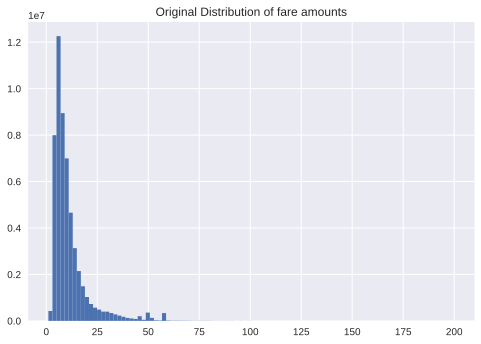

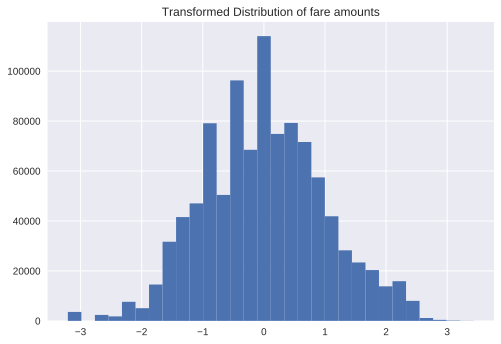

In [0]:
# Plot distribution of fares
plt.hist(train['fare_amount'], bins=100)
plt.title('Original Distribution of fare amounts')
plt.show()

# Plot distribution of fares around 0
tfmd_y_taxi = np.log(np.log10(y_taxi))
tfmd_y_taxi = (tfmd_y_taxi-np.mean(tfmd_y_taxi))/np.std(tfmd_y_taxi)
plt.hist(tfmd_y_taxi, bins=30)
plt.title('Transformed Distribution of fare amounts')
plt.show()

Now when we compute the prediction intervals using the transformed fare amounts, our predictive intervals are much more accurate.

In [0]:
# Compute predictive intervals
y_predL = cross_val_predict(gbrL, x_taxi, tfmd_y_taxi)
y_predH = cross_val_predict(gbrH, x_taxi, tfmd_y_taxi)

# Compute and show coverages
print('Coverage of top 97.5%%: %0.1f%%'
      % coverage(tfmd_y_taxi, y_predL, np.Inf))
print('Coverage of bottom 97.5%%: %0.1f%%'
      % coverage(tfmd_y_taxi, -np.Inf, y_predH))
print('Coverage of 95%% predictive interval: %0.1f%%'
      % coverage(tfmd_y_taxi, y_predL, y_predH))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Coverage of top 97.5%: 97.5%
Coverage of bottom 97.5%: 97.6%
Coverage of 95% predictive interval: 95.1%


Much better!

So our estimate of uncertainty is good overall, but is it accurate across the independent variables?  That is, is our model accounting for the heteroskedasticity in the data when estimating uncertainty?

If we plot the coverage of the 95% predictive interval as a function of the independent variables, we can see that our model isn't *completely* capturing the heteroskedasticity, but it's doing a bang-up job.  For example, looking at the coverage of the 95% predictive interval as a function of pickup time we can that the coverage changes across the course of a day.

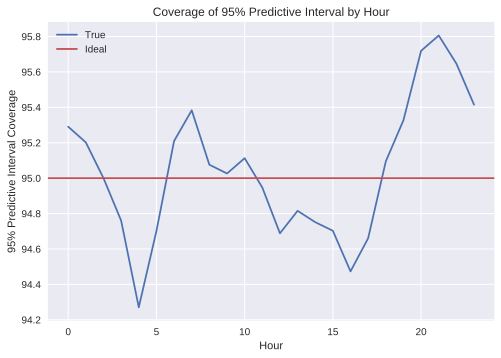

In [0]:
# Plot coverage as a fn of time of day
covs = np.zeros(24)
for iT in range(0,24):
  ix = ((x_taxi['min_of_day']>=(iT*60)) &
        (x_taxi['min_of_day']<((iT+1)*60)))
  covs[iT] = coverage(tfmd_y_taxi[ix], y_predL[ix], y_predH[ix])
plt.plot(covs, label='True')
plt.axhline(95.0, label='Ideal', color=colors[2])
plt.xlabel('Hour')
plt.ylabel('95% Predictive Interval Coverage')
plt.title('Coverage of 95% Predictive Interval by Hour')
plt.legend()
plt.show()

Plotting the coverage of the predictive interval by pickup location, we can see that the coverage varies across pickup locations as well.

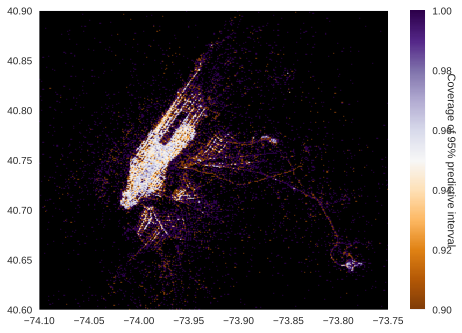

In [0]:
# Create vaex df with predictive intervals
x_taxi['predL'] = y_predL
x_taxi['predH'] = y_predH
x_taxi['log_fare_amount'] = tfmd_y_taxi
vdf = vaex.from_pandas(x_taxi)

# Compute coverage of the predictive interval
lims = [[-74.1, -73.75],[40.6, 40.9]]
covd = ((vdf.predL<vdf.log_fare_amount) &
              (vdf.predH>=vdf.log_fare_amount))
cov = vdf.mean(covd, limits=lims, shape=300,
               binby=[vdf.pickup_longitude,
                      vdf.pickup_latitude])

# Plot coverage of the predictive interval
cmap = matplotlib.cm.PuOr
cmap.set_bad('black', 1.)
plt.imshow(cov.T, origin='lower',
           vmin=0.9, vmax=1.0, cmap=cmap,
           extent=[lims[0][0], lims[0][1], 
                   lims[1][0], lims[1][1]])
ax = plt.gca()
ax.grid(False)
cbar = plt.colorbar()
cbar.set_label('Coverage of 95% predictive interval', 
               rotation=270)

The estimates of uncertainty are pretty good in downtown Manhattan (shades near white).  However, our model overestimates  uncertainty in some places like JFK airport and residential areas (shown in purple) and underestimates the uncertainty in other areas like Long Island City (just east of Manhattan across the river, shown in red).

## Conclusion

Quantile regressions are a great way to estimate uncertainty, but make sure your target variable is normally distributed and normalized!

# Dual-module Bayesian Neural Network

TODO: intro



In [0]:
!pip install -q tf-nightly
!pip install -q tfp-nightly
!pip install -q catboost
!pip install -q --pre vaex

In [0]:
# Packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import vaex
from sklearn.dummy import DummyRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict
from catboost import CatBoostRegressor
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

# Settings
sns.set()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%config InlineBackend.figure_format = 'svg'
np.random.seed(111)
tf.set_random_seed(111)

## Data

TODO: explain, mention more eda in previous post

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# Columns to load
dtypes = {'fare_amount':      'float32',
          'pickup_datetime':  'str', 
          'pickup_longitude': 'float32',
          'pickup_latitude':  'float32',
          'dropoff_longitude':'float32',
          'dropoff_latitude': 'float32'}

# Load data
#train = pd.read_csv('train.csv', 
train = pd.read_csv('/content/gdrive/My Drive/DataScience/Data/train.zip', 
                    usecols=dtypes.keys(), 
                    dtype=dtypes,
                    nrows=1000000)

# Convert pickup time column to datetime
train['pickup_datetime'] = train['pickup_datetime'].str.slice(0, 16)
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], 
                                          utc=True, format='%Y-%m-%d %H:%M')

In [0]:
# Drop rows with empty values
train.dropna(inplace=True)

# Extract useful time information
train['min_of_day'] = (60*train['pickup_datetime'].dt.hour + 
                       train['pickup_datetime'].dt.minute).astype('int32')
train['day_of_week'] = train['pickup_datetime'].dt.dayofweek.astype('int32')
train['day_of_year'] = train['pickup_datetime'].dt.dayofyear.astype('int32')
train['year'] = train['pickup_datetime'].dt.year.astype('int32')

# Remove original datetime column
train.drop('pickup_datetime', axis=1, inplace=True)

# Function to remove rows outside range
def clip(df, a, b, col):
    for c in col:
        df = df[(df[c]>a) & (df[c]<b)]
    return df

# Remove outliers
train = clip(train, 1, 200, ['fare_amount'])
train = clip(train,  -75, -72.5,
             ['pickup_longitude', 'dropoff_longitude'])
train = clip(train, 40, 41.5,
             ['pickup_latitude', 'dropoff_latitude'])

# Transform target column
train['fare_amount'] = np.log(np.log10(train['fare_amount']))

# Normalize data
train = (train - train.mean()) / train.std()

# Separate in- from dependent variables
x_taxi = train.drop('fare_amount', axis=1)
y_taxi = train['fare_amount']

## Baseline Models

In [0]:
# Make Mean Absolute Error scorer
mae_scorer = make_scorer(mean_absolute_error)

# Function to print cross-validated mean abs deviation
def cv_mae(regressor, x, y, cv=3, scorer=mae_scorer):
    scores = cross_val_score(regressor, 
                             x, y, cv=cv,
                             scoring=scorer)
    print('MAE:', scores.mean())

In [6]:
# MAE from predicting just the mean
cv_mae(DummyRegressor(), x_taxi, y_taxi)

MAE: 0.7930104533831278


In [7]:
# Distance between pickup and dropoff locations
dist = np.sqrt(
    np.power(x_taxi['pickup_longitude'] -
             x_taxi['dropoff_longitude'], 2) + 
    np.power(x_taxi['pickup_latitude'] - 
             x_taxi['dropoff_latitude'], 2))

# MAE from using just distance as predictor
cv_mae(IsotonicRegression(out_of_bounds='clip'), 
       dist, y_taxi)

MAE: 0.36685405935010573


## Vanilla Neural Network

TODO: talk about just prediction w/ nnet w/ MAE

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping

In [0]:
# Run simple keras model to get MAE
model = Sequential([
    Dense(128, activation='relu', input_shape=(x_taxi.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation=None)
])

In [0]:
# Compile the model using MAE
model.compile('adam',
              loss='mean_absolute_error')

In [30]:
# Stop training when we start to overfit
callbacks = [EarlyStopping(restore_best_weights=True,
                           patience=2)]

# Fit the model
model.fit(x_taxi, y_taxi,
          batch_size=1000,  epochs=10,
          validation_split=0.5,
          callbacks=callbacks,  verbose=2)

Train on 489552 samples, validate on 489552 samples
Epoch 1/10
 - 6s - loss: 0.5191 - val_loss: 0.3526
Epoch 2/10
 - 5s - loss: 0.3952 - val_loss: 0.3324
Epoch 3/10
 - 5s - loss: 0.3795 - val_loss: 0.3238
Epoch 4/10
 - 5s - loss: 0.3735 - val_loss: 0.3204
Epoch 5/10
 - 5s - loss: 0.3710 - val_loss: 0.3211
Epoch 6/10
 - 5s - loss: 0.3686 - val_loss: 0.3136
Epoch 7/10
 - 5s - loss: 0.3665 - val_loss: 0.3167
Epoch 8/10
 - 5s - loss: 0.3658 - val_loss: 0.3175


## Bayesian Neural network

TODO: fit the bayesian nnet w/ a single std dev param

## Dual-Module Bayesian Neural Network

TODO: fit the bayesian nnet which separately estimates the unceratinty from the prediction

compare coverage of 95% interval and performance w/ heteroskedasticity to the first nnet

In [0]:
# Settings
batch_size = 512
max_steps = 2000
learning_rate = 0.005

In [0]:
# DEBUGGER: reset the graph so you can re-run
tf.reset_default_graph() 

In [0]:
def build_input_pipeline(x, y, x_val, y_val, batch_size, N_val):
  '''Build an Iterator switching between train and heldout data.
  Args:
    x: Numpy `array` of training features, indexed by the first dimension.
    y: Numpy `array` of training labels, with the same first dimension as `x`.
    x_val: Numpy `array` of validation features, indexed by the first dimension.
    y_val: Numpy `array` of validation labels, with the same first dimension as `x_val`.
    batch_size: Number of elements in each training batch.
    N_val: Number of examples in the validation dataset
  Returns:
    batch_features: `Tensor` feed  features, of shape
      `[batch_size] + x.shape[1:]`.
    batch_labels: `Tensor` feed of labels, of shape
      `[batch_size] + y.shape[1:]`.
  '''
  # Build an iterator over training batches.
  training_dataset = tf.data.Dataset.from_tensor_slices((x, y))
  training_batches = training_dataset.shuffle(
      50000, reshuffle_each_iteration=True).repeat().batch(batch_size)
  train_iterator = training_batches.make_one_shot_iterator()

  # Build a iterator over the validation set with batch_size=N_val,
  # i.e., return the entire heldout set as a constant.
  val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
  val_frozen = val_dataset.take(N_val).repeat().batch(N_val)
  val_iterator = val_frozen.make_one_shot_iterator()

  # Combine these into a feedable iterator that can switch between training
  # and validation inputs.
  handle = tf.placeholder(tf.string, shape=[])
  feedable_iterator = tf.data.Iterator.from_string_handle(
      handle, training_batches.output_types, training_batches.output_shapes)
  batch_features, batch_labels = feedable_iterator.get_next()

  return batch_features, batch_labels, handle, train_iterator, val_iterator

# Build input pipeline
x_vals, y_vals,  handle, training_iterator, validation_iterator = (
    build_input_pipeline(x, y, x_val, y_val, batch_size, N_val) )

In [0]:
# A dense network specified by a list of Nunits per layer
def DenseNetReg(layers, x_in)
  prior = tfp.layers.default_mean_field_normal_fn()
  for units in layers:
    layer = tfp.layers.DenseFlipout(
      units=units, 
      kernel_posterior_fn=prior,
      bias_posterior_fn=prior)
    x_in = layer(x_in)
  layer = tfp.layers.DenseFlipout( #final layer w/ no activation
      units=1, 
      activation=None,
      kernel_posterior_fn=prior,
      bias_posterior_fn=prior)
  return layer(x_in)

# A linear regression model: a Normal distribution
# parameterized by location from a dense multi-layer net,
# and std dev frmo a dense multi-layer net
with tf.name_scope("dual_module_regression", values=[x_vals]):
  predictions = DenseNetReg([32, 16, 8], x_vals)  
  noise_std = DenseNetReg([32, 16, 8], x_vals)  
  pred_distribution = tfd.Normal(loc=predictions, 
                                 scale=noise_std)

In [0]:
# Compute the -ELBO as the loss, averaged over the batch size
neg_log_likelihood = -tf.reduce_mean(pred_distribution.log_prob(y_vals))
kl_div = sum(layer.losses) / N #TODO: need to sum losses from all layers?
elbo_loss = neg_log_likelihood + kl_div

# Mean absolute error metric for evaluation
mse, mse_update_op = tf.metrics.mean_absolute_error(
    labels=y_vals, predictions=predictions)

# Use ADAM optimizer w/ -ELBO loss
with tf.name_scope("train"):
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  train_op = optimizer.minimize(elbo_loss)

In [0]:
# To store parameter values over training
weight_mean = layer.kernel_posterior.mean()[:,0]
weight_std = layer.kernel_posterior.stddev()[:,0]
bias_mean = layer.bias_posterior.mean()
bias_std = layer.bias_posterior.stddev()
noise_std_mean = noise_std.mean()
noise_std_std = noise_std.stddev()
weight_means = np.zeros((max_steps, D))
weight_stds = np.zeros((max_steps, D))
bias_means = np.zeros(max_steps)
bias_stds = np.zeros(max_steps)
noise_stds = np.zeros(max_steps)
noise_means = np.zeros(max_steps)
mses = np.zeros(max_steps)
losses = np.zeros(max_steps)

# Initialization op
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

# Run the training session
with tf.Session() as sess:
  sess.run(init_op)

  # Training loop
  train_handle = sess.run(training_iterator.string_handle())
  val_handle = sess.run(validation_iterator.string_handle())
  with Timer():
    for iS in range(max_steps):
      [
          _,
          _,
          mses[iS],
          losses[iS],
          weight_means[iS,:],
          weight_stds[iS,:],
          bias_means[iS],
          bias_stds[iS],
          noise_means[iS],
          noise_stds[iS]
      ] = sess.run([
          train_op,
          mse_update_op,
          mse,
          elbo_loss,
          weight_mean,
          weight_std,
          bias_mean,
          bias_std,
          noise_std_mean,
          noise_std_std
      ], feed_dict={handle: train_handle})

  # Draw samples from the posterior
  Nmc = 1000
  w_draw = layer.kernel_posterior.sample(Nmc)
  b_draw = layer.bias_posterior.sample(Nmc)
  n_draw = noise_std.sample(Nmc)
  w_post, b_post, n_post = sess.run([w_draw, b_draw, n_draw])
  
  # Draw predictive distribution samples
  prediction_dist_var = sess.run((pred_distribution.sample(Nmc)), 
                                 feed_dict={handle: val_handle})

In [0]:
# Compute proportion of estimates on validation data 
# which fall within the 95% prediction interval
q0 = 2.5
q1 = 97.5
within_conf_int = np.zeros(N_val)
for i in range(N_val):
  pred_dist = prediction_dist_var[:, i, 0]
  p0 = np.percentile(pred_dist, q0)
  p1 = np.percentile(pred_dist, q1)
  if p0<=y_val[i] and p1>y_val[i]:
    within_conf_int[i] = 1

print('%0.1f %% of validation samples are w/i the %0.1f %% prediction interval' 
      % (100*np.mean(within_conf_int), q1-q0))